# Using Benford's Law to Analyze Covid-19 Data 

## Data Storytelling

Benford's law, also known as the `first digits law`, is a law used to detect if there is any flaws or fraud in data collection. It stipulates that frequencies of first digits in naturally occurring numerical distributions, with multiple changes of magnitude, follow a particular logarithmic distribution:

$$ P(d) = \log_{10}\left(1 + \dfrac{1}{d}  \right)$$ 

Where **P(d)** is the the probability of the leading digit **d** and **d** varies from **1 to 9**.

With more than a year since the Covid-19 pandemic appended our lives, as we hope to start breathing as sigh of relief soon, we can start asking ourselves few questions. Yes, maybe the most pertinent question is where the virus came from and why response to it was generally disastrous, but we choose a more practical question: should we trust the data provided to us by different countries? How can we tell if some data present anomalies? Using Benford's law, we will check if the data provided to us **tend** to agree with Benford's distribution. 

First, let's import relevant packages and modules

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt 
import requests
import collections
import random
import math
from scipy import stats
import scipy.stats
from scipy.stats.distributions import chi2

We show now how the Benford's distribution looks like:

Text(0, 0.5, 'Frequency (%)')

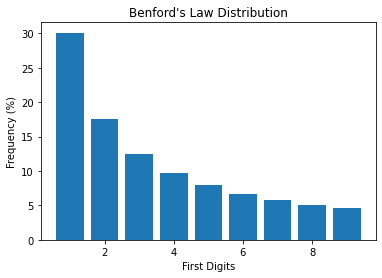

In [2]:
# Benford's law
x_ben = np.array([1,2,3,4,5,6,7,8,9])
y_ben = np.log10(np.ones(9) + 1/x_ben) * 100

plt.bar(x_ben, y_ben, width=0.8)
plt.title("Benford's Law Distribution")
plt.xlabel('First Digits')
plt.ylabel('Frequency (%)')

The law predicts, that the leading digit **1**, occurs **30.1%** of the time, **2** occurs **17.6%** of the time, etc., with **9** occuring lastly about **4.6%** of the time.

We are now going to create an on object that returns a plot of given data vs a Benford distribution in count data (not percentage). This object works for any data we want to compare to benford's distribution, so we will use to analyse covd-19 data.

In [3]:

class BenfordsLawDetector:
    """
    Class to plot and test observed vs expected digits in count data.
    """
    digits = np.array([1,2,3,4,5,6,7,8,9])
   
   # Creating and initializing an instance whose attribute is a list of numbers
    def __init__(self, numbers):
        self.numbers = numbers
        self.first_digit_freq = self._get_first_digit_frequencies()
        self.observed_freq = [i for i in self.first_digit_freq.values()]
        self.expected_freq = self._get_expected_freqencies()
        
   # making a function that, given any integer, returns the first digit
    @staticmethod
    def get_first_digit(number: int):
        while (number >= 10):
            number = number // 10
        return number
    
    
    # Making a function that counts the number of first digits and returns their frequencies
    def _get_first_digit_frequencies(self):
        leading_digits = [self.get_first_digit(i) for i in self.numbers if i != 0]
        freq = {i:0 for i in range(1,10)}
        for item in leading_digits:
            if (item in freq):
                freq[item] += 1
            else:
                freq[item] = 1
        return collections.OrderedDict(sorted(freq.items()))
    
   # Making a function that returns expected frequencies from the Benford's distribution
    def _get_expected_freqencies(self):
       
        total_count = sum([i for i in self.first_digit_freq.values()])
        return np.log10(np.ones(9) + 1/self.digits) * total_count
    
    def _get_observed_freqencies(self):
        return [i for i in self.first_digit_freq.values()]
    
    
    # making a function that plots the first digits in a given data alongslide Benford's distribution
    def plot(self, title='Distribution of First Digits'):

        plt.plot(self.digits, self.observed_freq, label='Frequency')
        plt.plot(self.digits, self.expected_freq, label='benford\'s law')
        plt.ylabel('Frequency')
        plt.xlabel('First Digits')
        plt.title(title)
        plt.legend()
        plt.show()
   # making another function that returns the chi-square statistics
    def test(self, method='chisquare'):
        if method != 'chisquare':
            raise ValueError('Only chisquare implemented!')
        chisq, p = chisquare(self.observed_freq, self.expected_freq, ddof=8)
        return chisq, p

We are importing covid-19 data, they include the number of confirmed cases, deaths and recoveries wordlwide, and the number for US only.

In [4]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
us_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-03-2021.csv')
url = "https://covid.cdc.gov/covid-data-tracker/COVIDData/getAjaxData"
data = requests.get(url, params={"id": "US_MAP_DATA"}).json()
raw_df = pd.DataFrame(data["US_MAP_DATA"])


In [5]:
confirmed_df.drop(columns=['Lat', 'Long'], inplace=True)
deaths_df.drop(columns=['Lat', 'Long'], inplace=True)
recoveries_df.drop(columns=['Lat', 'Long'], inplace=True)
us_data.drop(columns=['Lat', 'Long_'], inplace=True)

Let's first make a brief analysis of our data

### How many countries are represented in this dataset?

In [6]:
confirmed_df['Country/Region'].nunique()

196

In [7]:
confirmed_df['Country/Region'].nunique() == deaths_df['Country/Region'].nunique()

True

### What is the total number of confirmed cases worldwide today?

In [8]:
confirmed_df_T = confirmed_df.T
confirmed_df_T1 = confirmed_df_T.iloc[2:]
total_confirmed = confirmed_df_T1.sum(axis=1).reset_index()
total_confirmed.rename(columns={'index':'date', 0: "num_cases"}, inplace=True)
total_confirmed['num_cases'].iloc[-1]

249878373.0

### How many people have died as of today from Covid-19?

In [9]:
deaths_df_T = deaths_df.T
deaths_df_T1 = deaths_df_T.iloc[2:]
total_deaths = deaths_df_T1.sum(axis=1).reset_index()
total_deaths.rename(columns={'index':'date', 0: "num_cases"}, inplace=True)
total_deaths['num_cases'].iloc[-1]

5049273.0

### How many people have recovered as of today from Covid-19?

In [10]:
recoveries_df_T = recoveries_df.T
recoveries_df_T1 = recoveries_df_T.iloc[2:]
total_recoveries = recoveries_df_T1.sum(axis=1).reset_index()
total_recoveries.rename(columns={'index':'date', 0: "num_cases"}, inplace=True)
total_recoveries['num_cases'].iloc[-1]

0.0

In [11]:
# function to get unique values
def _unique(list1):
    x = np.array(list1)
    return np.unique(x)

We start with the global number of confirmed casees

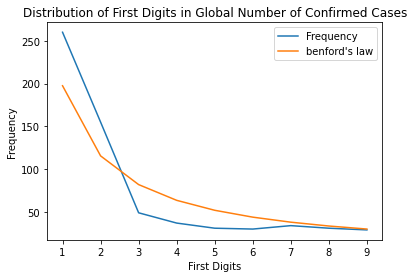

In [14]:
list_data_total_confirmed = total_confirmed['num_cases'].tolist()
global_data_confirmed = BenfordsLawDetector([int(i) for i in _unique(list_data_total_confirmed) ])
global_data_confirmed.plot('Distribution of First Digits in Global Number of Confirmed Cases')

The figure above shows thatdistribution of numbers of covid-19 confirmed cases worldwide somehow agree with the Benford's law. To evaluate the degree of deviation between the observed data, in our case the number of confirmed cases, and  the expected data, in our case the benford's law, we used the `chi square test`. We can estimate the value of $\chi^2$, the chi statistic, to be:

$$\chi^2 = \sum_{i=1}^{9} \dfrac{\left( O_i - E_i \right)^2}{E_i} $$
where $O_i$ and $E_i$ are the observed and expected frequencies respectfully. The value for $\chi^2$ in this case is,

In [12]:
def ChiSquareTest(Obs, Exp):
    chi_square = sum( (Obs - Exp) ** 2 / Exp for (Obs, Exp) in zip(Obs, Exp) )
    stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
    return print('The chi square statistic is', chi_square)

In [15]:
expected_confirmed = global_data_confirmed._get_expected_freqencies()
observed_confirmed = global_data_confirmed._get_observed_freqencies()
ChiSquareTest(observed_confirmed, expected_confirmed)

The chi square statistic is 71.16720522056299


In [16]:
scipy.stats.chi2.ppf(1-.05, df=8)

15.50731305586545

With a **95%** confidence level, $\chi^2(8) = 15.5073$, is the chi-square critical value, below which we accept that our data follow a benford's distribution, and above which we conclude that our data don't fit benford's distribution. Since $\chi^2$ of our data is about **17**, we conclude that our data for global numbers of confirmed cases don't quite fit the benford's distribution, even though it's close. We expect our data to match the benford's distribution, in the period pre-lockdown (but with enough data that is the entire period leading to lockdown or right after lockdown since the effects don't take place immediately) more than the whole period where the data were acquired, because before lockdown or  before other mitigations like enforcing face masks or social distancing were successfully enforced, data were being produced a little more naturally, and after mitigations, we can assume our data to be **treatment**. 

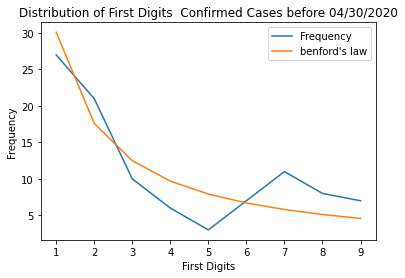

In [22]:
#total_confirmed_before = total_confirmed[total_confirmed['date'] <='04/30/20']
total_confirmed_before = total_confirmed.head(100)
#total_confirmed_before.head()
list_data_total_confirmed_before = total_confirmed_before['num_cases'].tolist()
global_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_total_confirmed_before])
global_data_confirmed_before.plot('Distribution of First Digits  Confirmed Cases before 04/30/2020')

In [23]:
ChiSquareTest(global_data_confirmed_before._get_observed_freqencies(), global_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 13.520473112814056


Therefore, **100 days** after the first case was found in US (**01/22**), the chi-square statistic between the total number of confirmed cases globally and the benford's distribution, was **13.019** which is less than the critical value of **15.507**, meaning that the data matched the benford's distribution.

We then looked at the total number of deaths globally,

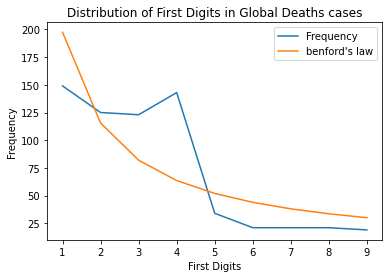

In [26]:
list_data_total_deaths = total_deaths['num_cases'].tolist()
#total_deaths.head()
global_data_deaths = BenfordsLawDetector([int(i) for i in list_data_total_deaths ])
global_data_deaths.plot('Distribution of First Digits in Global Deaths cases')

We checked how much our data deviate from benford's distribution,

In [193]:
ChiSquareTest(global_data_deaths._get_observed_freqencies(), global_data_deaths._get_expected_freqencies())

The chi square statistic is 37.53886524085768


The distribution of number of deaths globally, does not match the benford's law, because probably in many countries, the number of deaths was undercounted. We checked, if there is an improvement in the fitting when using the data before 04/30/3020,

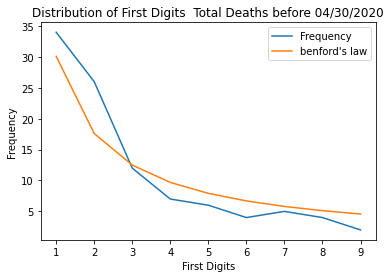

In [28]:
total_deaths_before = total_deaths.head(100)
list_data_total_deaths_before = total_deaths_before['num_cases'].tolist()
global_data_deaths_before = BenfordsLawDetector([int(i) for i in list_data_total_deaths_before])
global_data_deaths_before.plot('Distribution of First Digits  Total Deaths before 04/30/2020')

In [198]:
ChiSquareTest(global_data_deaths_before ._get_observed_freqencies(), global_data_deaths_before ._get_expected_freqencies())

The chi square statistic is 7.489092122257512


And, exactly the chi-square value of the distribution is about **7.489** which is half the critical value of $\chi^2$ below which we can conclude that our data fits Benford distribution.

In [29]:
def data_per_country(df, country):
    
    df_country = df.loc[df['Country/Region'] == country]
    df_country_T = df_country.T
    
    df_country_data = df_country_T.iloc[4:].reset_index()
    df_country_data.rename(columns={'index':'date', df_country.index[0]: "num_cases"}, inplace=True)
    #list_data_country = df_country_data['conf_cases'].tolist()
    return  df_country_data 


def data_per_country_before(df, country, d):
    
    df_country = df.loc[df['Country/Region'] == country]
    df_country_T = df_country.T
    
    df_country_data = df_country_T.iloc[4:].reset_index()
    df_country_data.rename(columns={'index':'date', df_country.index[0]: "num_cases"}, inplace=True)
    df_country_data =  df_country_data.head(d)
   # list_data_country = df_country_data['conf_cases'].tolist()
    return  df_country_data 

##  United States

### What is the total number of confirmed cases in US today?

In [30]:
us_confirmed = data_per_country(confirmed_df, 'US')
us_confirmed['num_cases'].iloc[-1]

46487791

### Total Confirmed Cases

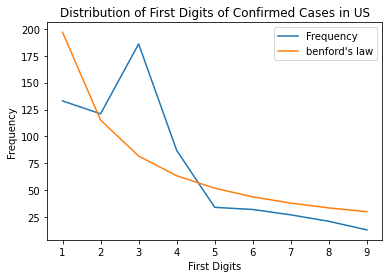

In [31]:
list_data_us_confirmed = us_confirmed['num_cases'].tolist()
us_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_us_confirmed])
us_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in US')

In [32]:
ChiSquareTest(us_data_confirmed._get_observed_freqencies(), us_data_confirmed._get_expected_freqencies())

The chi square statistic is 189.56817813217128


### Confirmed Cases Pre-Lockdown

In US, the CDC issued the stay at home guidance on April 03, 2020. Since the virus has an incubation period of more or less 7 days, we assumed that the CDC order started having an impact after April 10, 2020 or 80 days since the first case was detected in US.

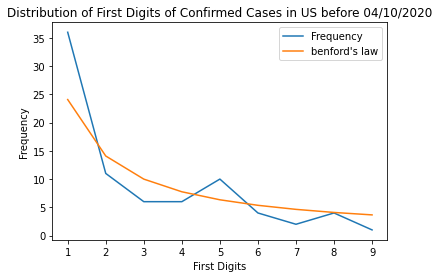

In [33]:
us_confirmed_before = data_per_country_before(confirmed_df, 'US', 80)
list_data_us_confirmed_before = us_confirmed_before['num_cases'].tolist()
us_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_us_confirmed_before])
us_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in US before 04/10/2020')

In [34]:
ChiSquareTest(us_data_confirmed_before._get_observed_freqencies(), us_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 14.46903694691172


### Total Deaths

### How many people have died of Covid-19  in US as of today?

In [35]:
us_deaths = data_per_country(deaths_df, 'US')
us_deaths['num_cases'].iloc[-1]

754429

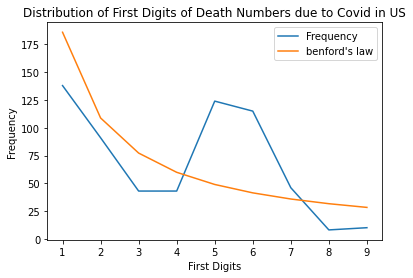

In [36]:
list_data_us_deaths = us_deaths['num_cases'].tolist()
us_data_deaths = BenfordsLawDetector([int(i) for i in list_data_us_deaths])
us_data_deaths.plot('Distribution of First Digits of Death Numbers due to Covid in US')

In [37]:
ChiSquareTest(us_data_deaths._get_observed_freqencies(), us_data_deaths._get_expected_freqencies())

The chi square statistic is 313.7558615249532


### Deaths Pre-Lockdown

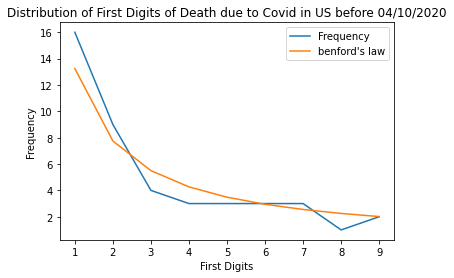

In [38]:
us_deaths_before = data_per_country_before(deaths_df, 'US', 80)
list_data_us_deaths_before = us_deaths_before['num_cases'].tolist()
us_data_deaths_before = BenfordsLawDetector([int(i) for i in list_data_us_deaths_before])
us_data_deaths_before.plot('Distribution of First Digits of Death due to Covid in US before 04/10/2020')

In [39]:
ChiSquareTest(us_data_deaths_before._get_observed_freqencies(), us_data_deaths_before._get_expected_freqencies())

The chi square statistic is 2.399861400098589


The number of confirmed cases and deaths worlwide and in US in particular, show as expected that the distribution of our data fit the Benford distribution more accurately before extreme majors were taken to slow down the infections, which makes sense. Now we will only check the case of confirmed cases overall and pre-lockdown if applicable in different countries to see if this trend holds or if some countries may have manipulated their numbers.

##  Canada

### Total Confirmed Cases

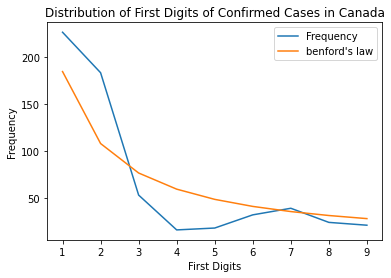

In [40]:
ca_confirmed = data_per_country(confirmed_df, 'Canada')
list_data_ca_confirmed = ca_confirmed['num_cases'].tolist()
ca_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_ca_confirmed])
ca_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in Canada')

In [41]:
ChiSquareTest(ca_data_confirmed._get_observed_freqencies(), ca_data_confirmed._get_expected_freqencies())

The chi square statistic is 125.72685824499237


### Confirmed Cases Pre-Lockdown

Canada also issued a lockdown order on April 03, 2020.

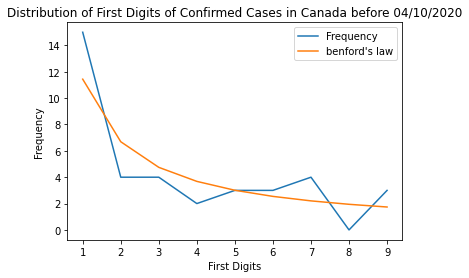

In [42]:
ca_confirmed_before = data_per_country_before(confirmed_df, 'Canada', 80)
list_data_ca_confirmed_before = ca_confirmed_before['num_cases'].tolist()
ca_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_ca_confirmed_before])
ca_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in Canada before 04/10/2020')

In [43]:
ChiSquareTest(ca_data_confirmed_before._get_observed_freqencies(), ca_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 7.482154077706984


##  Mexico

### Total Confirmed Cases 

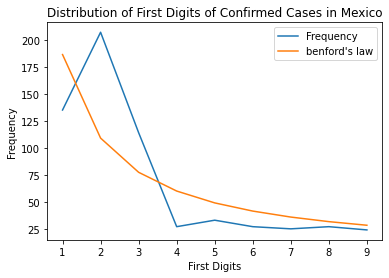

In [44]:
me_confirmed = data_per_country(confirmed_df, 'Mexico')
list_data_me_confirmed = me_confirmed['num_cases'].tolist()
me_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_me_confirmed])
me_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in Mexico')

In [45]:
ChiSquareTest(me_data_confirmed._get_observed_freqencies(), me_data_confirmed._get_expected_freqencies())

The chi square statistic is 152.69156143373306


### Confirmed Cases Pre-Lockdown

Mexico issued a lockdown order on March 31, 2020.

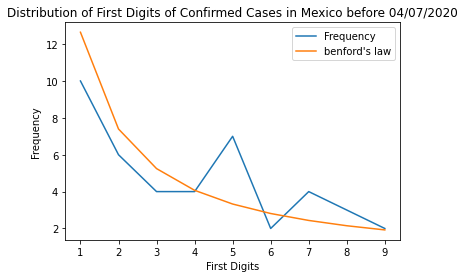

In [46]:
me_confirmed_before = data_per_country_before(confirmed_df, 'Mexico', 77)
list_data_me_confirmed_before = me_confirmed_before['num_cases'].tolist()
me_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_me_confirmed_before])
me_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in Mexico before 04/07/2020')

In [47]:
ChiSquareTest(me_data_confirmed_before._get_observed_freqencies(), me_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 6.753360709779717


## South Africa

### Total Confirmed Cases 

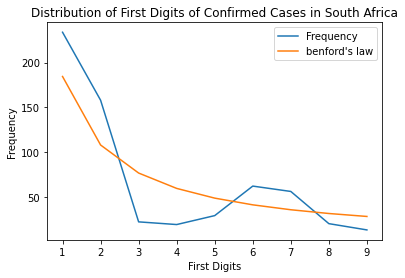

In [48]:
za_confirmed = data_per_country(confirmed_df, 'South Africa')
list_data_za_confirmed = za_confirmed['num_cases'].tolist()
za_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_za_confirmed])
za_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in South Africa')

In [49]:
ChiSquareTest(za_data_confirmed._get_observed_freqencies(), za_data_confirmed._get_expected_freqencies())

The chi square statistic is 145.38734998850646


### Confirmed Cases Pre-Lockdown

In South Africa, a national lockdown started on March 27, 2020.

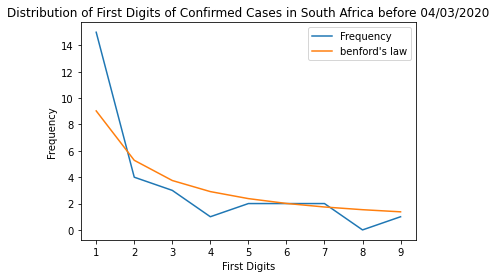

In [50]:
za_confirmed_before = data_per_country_before(confirmed_df, 'South Africa', 71)
list_data_za_confirmed_before = za_confirmed_before['num_cases'].tolist()
za_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_za_confirmed_before])
za_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in South Africa before 04/03/2020')

In [51]:
ChiSquareTest(za_data_confirmed_before._get_observed_freqencies(), za_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 7.391511704228616


## Russia

### Total Confirmed Cases

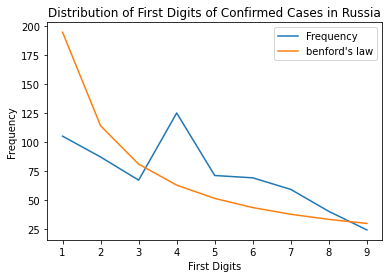

In [52]:
ru_confirmed = data_per_country(confirmed_df, 'Russia')
list_data_ru_confirmed = ru_confirmed['num_cases'].tolist()
ru_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_ru_confirmed])
ru_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in Russia')

In [53]:
ChiSquareTest(ru_data_confirmed._get_observed_freqencies(), ru_data_confirmed._get_expected_freqencies())

The chi square statistic is 149.66497606541708


### Total Confirmed Cases Within the First 75 Days

Although Russia, never issued a lockdown order, we can still check how the data behaved with respect to the Benford distribution earlier before many people started wearing masks, and adhering to other measures. Many countries did not issue a consisten lockdown, others issues multiple lockdowns each lasting few weeks. Since the countries we discussed above issued the first lockdown order or guideline within $75 \pm 5$ days after the first case was detected in their respective countries, we chose an average of **75 days** since the first case was detected to be the the data pre-lockdown for Russia and all other countries below:

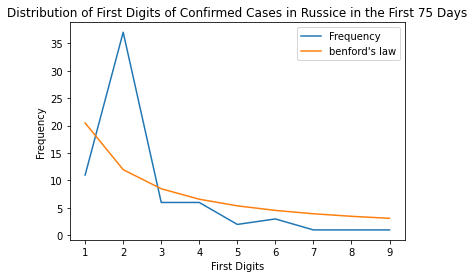

In [54]:
ru_confirmed_before = data_per_country_before(confirmed_df, 'Russia', 75)
list_data_ru_confirmed_before = ru_confirmed_before['num_cases'].tolist()
ru_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_ru_confirmed_before])
ru_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in Russice in the First 75 Days')

In [55]:
ChiSquareTest(ru_data_confirmed_before._get_observed_freqencies(), ru_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 65.52280494410726


## Italy

### Total Confirmed Cases

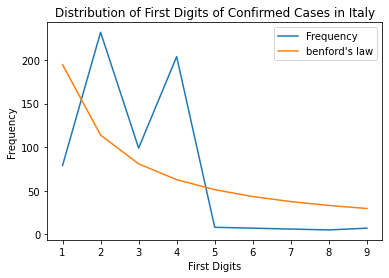

In [56]:
it_confirmed = data_per_country(confirmed_df, 'Italy')
list_data_it_confirmed = it_confirmed['num_cases'].tolist()
it_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_it_confirmed])
it_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in Italy')

In [57]:
ChiSquareTest(it_data_confirmed._get_observed_freqencies(), it_data_confirmed._get_expected_freqencies())

The chi square statistic is 648.1903742881278


### Confirmed Cases Pre-Lockdown

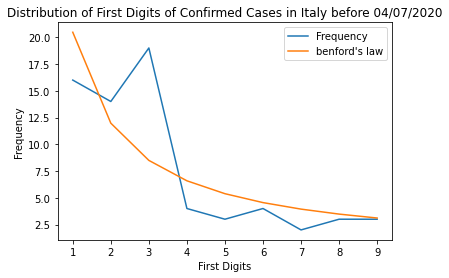

In [58]:
it_confirmed_before = data_per_country_before(confirmed_df, 'Italy', 75)
list_data_it_confirmed_before = it_confirmed_before['num_cases'].tolist()
it_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_it_confirmed_before])
it_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in Italy before 04/07/2020')

In [59]:
ChiSquareTest(it_data_confirmed_before._get_observed_freqencies(), it_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 17.474385545725628


## Saudi Arabia

### Total Confirmed Cases 

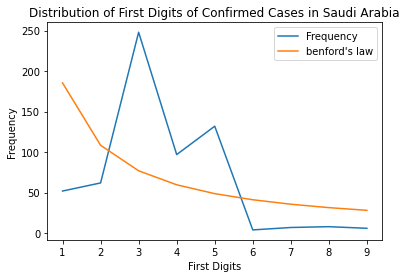

In [60]:
sa_confirmed = data_per_country(confirmed_df, 'Saudi Arabia')
list_data_sa_confirmed = sa_confirmed['num_cases'].tolist()
sa_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_sa_confirmed])
sa_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in Saudi Arabia')

In [61]:
ChiSquareTest(sa_data_confirmed._get_observed_freqencies(), sa_data_confirmed._get_expected_freqencies())

The chi square statistic is 753.0736766006595


### Total Confirmed Cases Within the First 75 Days

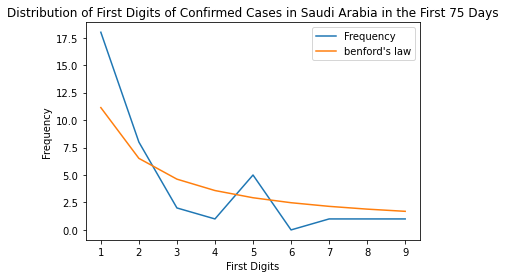

In [62]:
sa_confirmed_before = data_per_country_before(confirmed_df, 'Saudi Arabia', 75)
list_data_sa_confirmed_before = sa_confirmed_before['num_cases'].tolist()
sa_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_sa_confirmed_before])
sa_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in Saudi Arabia in the First 75 Days')

In [63]:
ChiSquareTest(sa_data_confirmed_before._get_observed_freqencies(), sa_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 13.174756214329694


## Philippines

### Total Confirmed Cases

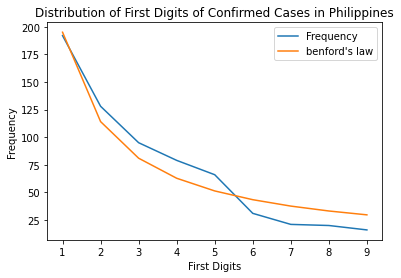

In [64]:
ph_confirmed = data_per_country(confirmed_df, 'Philippines')
list_data_ph_confirmed = ph_confirmed['num_cases'].tolist()
ph_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_ph_confirmed])
ph_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in Philippines')

In [65]:
ChiSquareTest(ph_data_confirmed._get_observed_freqencies(), ph_data_confirmed._get_expected_freqencies())

The chi square statistic is 34.90779872895544


### Total Confirmed Cases Within the First 75 Days

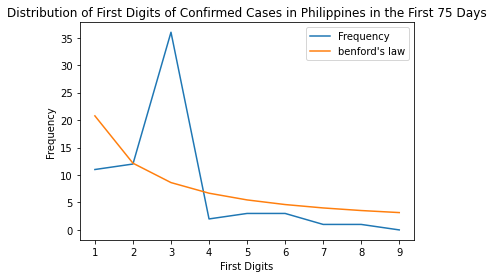

In [66]:
ph_confirmed_before = data_per_country_before(confirmed_df, 'Philippines', 75)
list_data_ph_confirmed_before = ph_confirmed_before['num_cases'].tolist()
ph_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_ph_confirmed_before])
ph_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in Philippines in the First 75 Days')

In [67]:
ChiSquareTest(ph_data_confirmed_before._get_observed_freqencies(), ph_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 103.73857938319081


## China

### Total Confirmed Cases 

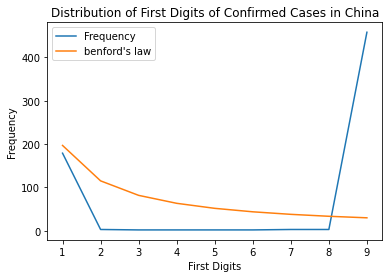

In [68]:
ch_confirmed = data_per_country(confirmed_df, 'China')
list_data_ch_confirmed = ch_confirmed['num_cases'].tolist()
ch_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_ch_confirmed])
ch_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in China')

In [69]:
ChiSquareTest(ch_data_confirmed._get_observed_freqencies(), ch_data_confirmed._get_expected_freqencies())

The chi square statistic is 6519.17828210189


### Total Confirmed Cases Within the First 75 Days

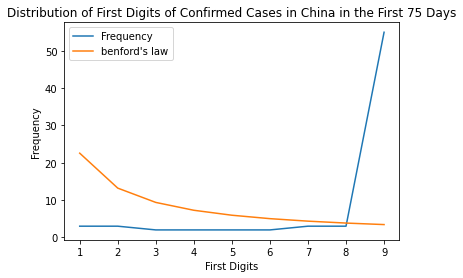

In [70]:
ch_confirmed_before = data_per_country_before(confirmed_df, 'China', 75)
list_data_ch_confirmed_before = ch_confirmed_before['num_cases'].tolist()
ch_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_ch_confirmed_before])
ch_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in China in the First 75 Days')

In [71]:
ChiSquareTest(ch_data_confirmed_before._get_observed_freqencies(), ch_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 814.4012966059918


## India

### Total Confirmed Cases 

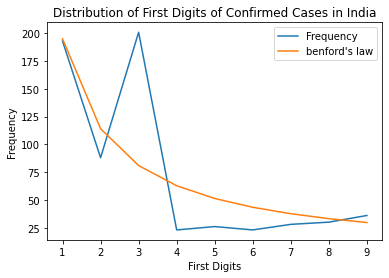

In [72]:
in_confirmed = data_per_country(confirmed_df, 'India')
list_data_in_confirmed = in_confirmed['num_cases'].tolist()
in_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_in_confirmed])
in_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in India')

In [73]:
ChiSquareTest(in_data_confirmed._get_observed_freqencies(), in_data_confirmed._get_expected_freqencies())

The chi square statistic is 235.35928454527559


### Total Confirmed Cases Within the First 75 Days

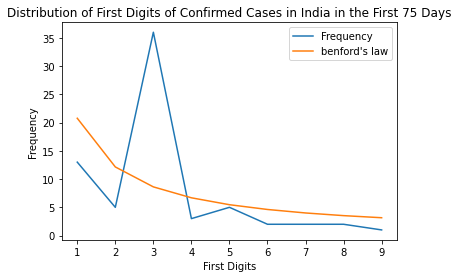

In [74]:
in_confirmed_before = data_per_country_before(confirmed_df, 'India', 75)
list_data_in_confirmed_before = in_confirmed_before['num_cases'].tolist()
in_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_in_confirmed_before])
in_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in India in the First 75 Days')

In [75]:
ChiSquareTest(in_data_confirmed_before._get_observed_freqencies(), in_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 100.76577528812766


## Nigeria

### Total Confirmed Cases 

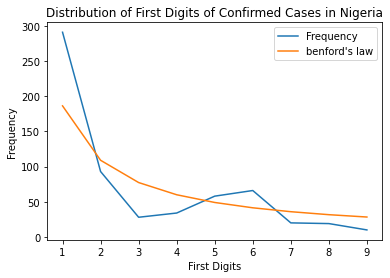

In [76]:
ni_confirmed = data_per_country(confirmed_df, 'Nigeria')
list_data_ni_confirmed = ni_confirmed['num_cases'].tolist()
ni_data_confirmed = BenfordsLawDetector([int(i) for i in list_data_ni_confirmed])
ni_data_confirmed.plot('Distribution of First Digits of Confirmed Cases in Nigeria')

In [77]:
ChiSquareTest(ni_data_confirmed._get_observed_freqencies(), ni_data_confirmed._get_expected_freqencies())

The chi square statistic is 144.03088093320696


### Total Confirmed Cases Within the First 75 Days

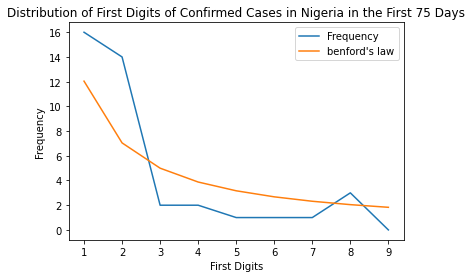

In [78]:
ni_confirmed_before = data_per_country_before(confirmed_df, 'Nigeria', 75)
list_data_ni_confirmed_before = ni_confirmed_before['num_cases'].tolist()
ni_data_confirmed_before = BenfordsLawDetector([int(i) for i in list_data_ni_confirmed_before])
ni_data_confirmed_before.plot('Distribution of First Digits of Confirmed Cases in Nigeria in the First 75 Days')

In [79]:
ChiSquareTest(ni_data_confirmed_before._get_observed_freqencies(), ni_data_confirmed_before._get_expected_freqencies())

The chi square statistic is 16.437964409994706


## Conclusion

In this project we analyzed data from different countries to check if they match with the Benford distribution. We calculated the critical value of $\chi^2$ in data with 8 degrees of freedom, and any data that had a $\chi^2$ that is less or equal to the critical value is said to match the Benford disribution. Our data chowed that most countries's provided data match the Benford distribution especially during the period where there was no intervention. But some countries like, China, Russia and India had data that do not much Benford distribution. This does not necessarily mean that there was tampering with the data, it may happen that people there were more cautious even without government intervention, or that the governments did not have the means to collect enough data that reflect the sitiation on the field.

## What Can we do next?

There are some questions that are left unanswered,
* How does the order of magnitude in each data depend on the accuracy in matching with Benford distribution?
* Is there a common factor among countries with very high $\chi^2$ (like political regime, size of the population, etc...)
* Can we reverse engineer the data that do not match Benford distribution, to make them look like they do?
* Subdivide the data into different periods of reflecting pandemic waves and measures to contain it. The data we have in 2021 look different that the data from 2020.